## Latent Dimention - First Exploration

Con la arquitectura de nuestro CAE determinada en 4.0, buscamos la dimensión mínima del espacio latente que pueda reproducir los datos de entrada con una dada precisión. Para eso vamos a entrenar distintos modelos en los que solo se varía la dimensión del espacio latente y buscar un codo en el score medio de las últimas 10 epochs.

In [1]:
import json
import os
import pickle

import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm

from deep_scattering_models.data.create_data import load_data
from deep_scattering_models.features.preprocess_data import to_dB
from deep_scattering_models.models.model_wrappers import build_cae_architecture
from deep_scattering_models.models.select_model import load_configuration, k_fold_cv, save_configuration
from deep_scattering_models.visualization.visualize import plot_polarization_signature, plot_history

Comenzamos cargando los datos y la configuración de nuestro CAE

In [2]:
raw_data_filename = "raw/spm_signatures_no_noise"
raw_data = load_data(raw_data_filename)

In [3]:
data_dB = to_dB(raw_data)
train_set, test_set = train_test_split(
    data_dB, 
    test_size=.2, 
    random_state=123
    )

In [4]:
cae_configuration = load_configuration("model_architecture_spm.json")

Variamos la dimensión del espacio latente de 16 unidades a 1 unidad. Registramos el MSE y el MAE del conjunto de testeo para cada una de las configuraciones.

In [5]:
# Initialize list for results
models_scores = []
not_tested_configurations = []

config_keys = ('conv_layers_config', 'dense_layers_config')

for lat_dim in tqdm(range(1, 17)):
    configuration = {keys : cae_configuration[keys] for keys in config_keys}
    configuration.update({"latent_dimension" : lat_dim})
    configuration.update({"batch_size" : 32})

    try:
        k_fold_score = k_fold_cv(
            train_set, 
            build_cae_architecture, 
            configuration
            )
    
    except tf.errors.ResourceExhaustedError:
        # If gpu memory is exhausted
        not_tested_configurations.append(configuration)
        
        raise Warning(('La actual configuración agotó los recursos '
        f'de memoria y no fue evaluada: \n {configuration}'))  
    
    else:
        # Update scores
        configuration.update(k_fold_score)
        models_scores.append(configuration)

    finally:
        continue    

100%|██████████| 16/16 [4:01:14<00:00, 904.65s/it]  


In [6]:
df_score = pd.DataFrame.from_records(models_scores)
df_score

,conv_layers_config,dense_layers_config,latent_dimension,batch_size,score,train_score
0,"{'layers_config': [[4, ListWrapper([3, 4]), 2]...","{'layers_units': [256], 'dropout': True}",1,32,0.379594,0.408480
1,"{'layers_config': [[4, ListWrapper([3, 4]), 2]...","{'layers_units': [256], 'dropout': True}",2,32,0.270610,0.280969
2,"{'layers_config': [[4, ListWrapper([3, 4]), 2]...","{'layers_units': [256], 'dropout': True}",3,32,0.210932,0.245466
3,"{'layers_config': [[4, ListWrapper([3, 4]), 2]...","{'layers_units': [256], 'dropout': True}",4,32,0.201881,0.229182
4,"{'layers_config': [[4, ListWrapper([3, 4]), 2]...","{'layers_units': [256], 'dropout': True}",5,32,0.204780,0.230025
5,"{'layers_config': [[4, ListWrapper([3, 4]), 2]...","{'layers_units': [256], 'dropout': True}",6,32,0.210703,0.230427
6,"{'layers_config': [[4, ListWrapper([3, 4]), 2]...","{'layers_units': [256], 'dropout': True}",7,32,0.205596,0.226887
7,"{'layers_config': [[4, ListWrapper([3, 4]), 2]...","{'layers_units': [256], 'dropout': True}",8,32,0.210746,0.239416
8,"{'layers_config': [[4, ListWrapper([3, 4]), 2]...","{'layers_units': [256], 'dropout': True}",9,32,0.203980,0.227770
9,"{'layers_config': [[4, ListWrapper([3, 4]), 2]...","{'layers_units': [256], 'dropout': True}",10,32,0.204175,0.225065


Guardamos los scores serializados en un pkl

In [ ]:
# Get resutls directory path
src_dir = os.path.normpath(os.getcwd() + '/..')
results_dir = os.path.join(src_dir, 'results/spm')

# File name and dir
file_name = 'spm_ld_scores.pkl'
file_dir = os.path.join(results_dir, file_name)

# Save model_scores as pkl
with open(file_dir, 'wb') as f:
    pickle.dump(models_scores, f)

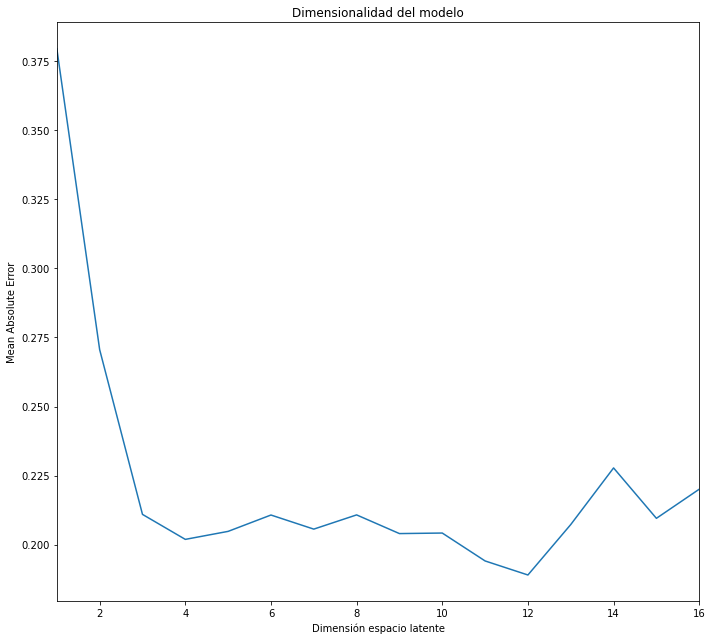

In [7]:
from matplotlib import pyplot as plt
# Visualizo los errores -  Mean Absolute error
fig, ax = plt.subplots(figsize = (10,9))
ax.plot(range(1, 17), df_score['score'])
ax.set_title('Dimensionalidad del modelo')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlabel('Dimensión espacio latente')
ax.set_xlim((1, 16))
plt.tight_layout()